In [4]:
"""
Predict
"""
from datetime import datetime
from tqdm import tqdm
import numpy as np
import random, os, sys, torch, cv2, warnings
from glob import glob
from torch.utils.data import DataLoader

prj_dir = os.path.dirname(os.path.abspath("baseline")) # for jupyter
sys.path.append(prj_dir)

from modules.utils import load_yaml, save_yaml, get_logger
from modules.scalers import get_image_scaler
from modules.datasets import SegDataset
from models.utils import get_model
warnings.filterwarnings('ignore')

In [5]:
prj_dir

'/home/fds/Downloads/Military_AI_CompetitiON/maicon_codes_computer_room_5(Refer to codes in this folder)'

In [7]:

if __name__ == '__main__':

    #! Load config
    config = load_yaml(os.path.join(prj_dir, 'config', 'predict.yaml'))
    train_config = load_yaml(os.path.join(prj_dir, 'results', 'train', config['train_serial'], 'train.yaml'))
    
    #! Set predict serial
    pred_serial = config['train_serial'] + '_' + datetime.now().strftime("%Y%m%d_%H%M%S")

    # Set random seed, deterministic
    torch.cuda.manual_seed(train_config['seed'])
    torch.manual_seed(train_config['seed'])
    np.random.seed(train_config['seed'])
    random.seed(train_config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set device(GPU/CPU)
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['gpu_num'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create train result directory and set logger
    pred_result_dir = os.path.join(prj_dir, 'results', 'pred', pred_serial)
    pred_result_dir_mask = os.path.join(prj_dir, 'results', 'pred', pred_serial, 'mask')
    os.makedirs(pred_result_dir, exist_ok=True)
    os.makedirs(pred_result_dir_mask, exist_ok=True)

    # Set logger
    logging_level = 'debug' if config['verbose'] else 'info'
    logger = get_logger(name='train',
                        file_path=os.path.join(pred_result_dir, 'pred.log'),
                        level=logging_level)

    # Set data directory
    test_dirs = os.path.join(prj_dir, 'data', 'test')
    test_img_paths = glob(os.path.join(test_dirs, 'x', '*.png'))

    #! Load data & create dataset for train 
    test_dataset = SegDataset(paths=test_img_paths,
                            input_size=[train_config['input_width'], train_config['input_height']],
                            scaler=get_image_scaler(train_config['scaler']),
                            mode='test',
                            logger=logger)

    # Create data loader
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=config['batch_size'],
                                num_workers=config['num_workers'],
                                shuffle=False,
                                drop_last=False)
    logger.info(f"Load test dataset: {len(test_dataset)}")

    # Load architecture
    model = get_model(model_str=train_config['architecture'])
    model = model(
                classes=train_config['n_classes'],
                encoder_name=train_config['encoder'],
                encoder_weights=train_config['encoder_weight'],
                activation=train_config['activation']).to(device)
    logger.info(f"Load model architecture: {train_config['architecture']}")

    #! Load weight
    check_point_path = os.path.join(prj_dir, 'results', 'train', config['train_serial'], 'model.pt')
    check_point = torch.load(check_point_path)
    model.load_state_dict(check_point['model'])
    logger.info(f"Load model weight, {check_point_path}")

    # Save config
    save_yaml(os.path.join(pred_result_dir, 'train_config.yml'), train_config)
    save_yaml(os.path.join(pred_result_dir, 'predict_config.yml'), config)

### Test predict

In [8]:
# Set data directory
train_dirs = os.path.join('..', 'data', 'train')
train_img_paths = glob(os.path.join(train_dirs, 'x', '*.png'))

train_dataset = SegDataset(paths=train_img_paths,
                        input_size=[train_config['input_width'], train_config['input_height']],
                        scaler=get_image_scaler(train_config['scaler']),
                        mode='test',
                        )

train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=config['batch_size'],
                                num_workers=config['num_workers'],
                                shuffle=False,
                                drop_last=False)

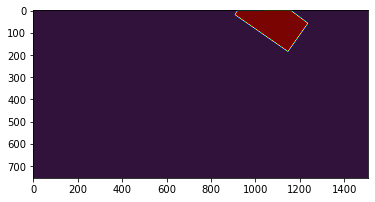

In [4]:
# from matplotlib import pyplot as plt
# img = "2017_MPG_2LB_000631.png"
# img_y_path = "../data/train/y"
# y_path = os.path.join(img_y_path,img)
# ground_truth = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
# plt.imshow(ground_truth, cmap='turbo')
# # plt.imshow(np.squeeze(result, 0), cmap='turbo')

 68%|██████▊   | 510/750 [01:33<00:44,  5.45it/s]

2019_KSG_1JY_000010.png


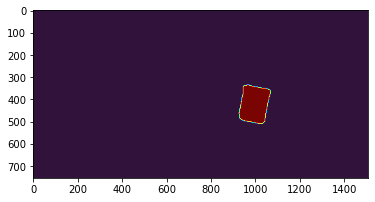

In [15]:
# Test predict
from matplotlib import pyplot as plt
# img = "2017_KRG_2LB_000887.png"
# img = "2017_MPG_2LB_000631.png"
img = "2019_KSG_1JY_000010.png"
flag = 0

plt.figure()
# f, axarr = plt.subplots(1,2, figsize=(15, 15)) 

img_x_path = "../data/train/x"
img_y_path = "../data/train/y"

model.eval()
cnt = 0
with torch.no_grad():
    for batch_id, (x, orig_size, filename) in enumerate(tqdm(train_dataloader)):
        if flag or img in filename:
            if cnt == 100 or img in filename:
                x = x.to(device, dtype=torch.float)
                y_pred = model(x)
                y_pred_argmax = y_pred.argmax(1).cpu().numpy().astype(np.uint8)
                orig_size = [(orig_size[0].tolist()[i], orig_size[1].tolist()[i]) for i in range(len(orig_size[0]))]
                # Save predict result
                c = 0
                for filename_, orig_size_, y_pred_ in zip(filename, orig_size, y_pred_argmax):
                    if flag or filename_ == img:
                        if c == 1:
                            break
                        img = filename_
                        print(img)
                        resized_img = cv2.resize(y_pred_, [orig_size_[1], orig_size_[0]], interpolation=cv2.INTER_NEAREST)
                        plt.imshow(resized_img, cmap='turbo', vmin=0,vmax=3)
                        # axarr[0].imshow(resized_img, cmap='turbo', vmin=0,vmax=3)

                        y_path = os.path.join(img_y_path,img)
                        # ground_truth = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
                        # axarr[1].imshow(ground_truth, cmap='turbo', vmin=0,vmax=3)
                    #     cv2.imwrite(os.path.join(pred_result_dir_mask, filename_), resized_img)
                        c += 1 
                break
            cnt += 1


### Predict test for submission

In [7]:
# Predict
logger.info(f"START PREDICTION")

model.eval()

with torch.no_grad():

    for batch_id, (x, orig_size, filename) in enumerate(tqdm(test_dataloader)):
        
        x = x.to(device, dtype=torch.float)
        y_pred = model(x)
        y_pred_argmax = y_pred.argmax(1).cpu().numpy().astype(np.uint8)
        orig_size = [(orig_size[0].tolist()[i], orig_size[1].tolist()[i]) for i in range(len(orig_size[0]))]
        # Save predict result
        for filename_, orig_size_, y_pred_ in zip(filename, orig_size, y_pred_argmax):
            resized_img = cv2.resize(y_pred_, [orig_size_[1], orig_size_[0]], interpolation=cv2.INTER_NEAREST)
            cv2.imwrite(os.path.join(pred_result_dir_mask, filename_), resized_img)
logger.info(f"END PREDICTION")

  0%|          | 0/147 [00:00<?, ?it/s]

100%|██████████| 147/147 [03:03<00:00,  1.25s/it]
